# LBM Demo Extraction 

In [38]:
## Imports
%load_ext autoreload
%autoreload 2

import time
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import tifffile

sys.path.append('../../util/')  # TODO: Take this out when we upload to pypi
sys.path.append('../..')  # TODO: Take this out when we upload to pypi
import matplotlib.pyplot as plt
import dask
import zarr
import scanreader as sr

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def clear_zeros(_scan, rmz_threshold=1e-5):
    non_zero_rows = ~np.all(np.abs(_scan) < rmz_threshold, axis=(0, 2))
    non_zero_cols = ~np.all(np.abs(_scan) < rmz_threshold, axis=(0, 1))
    cleaned = _scan[:, non_zero_rows, :]
    return cleaned[:, :, non_zero_cols]

## System and User Information
get_sys_info=False

if get_sys_info:
    !pip install cloudmesh-cmd5
    !cms help # sets some defaults
    !cms sysinfo

## Set up filepaths


In [19]:
# ScanReader object holds our image data with tifffile
parent_dir = Path().home() / 'caiman_data'
raw_dir = parent_dir / 'high_res'
raw_files = [str(x) for x in raw_dir.glob("*.tif*")]
raw_files

['/home/mbo/caiman_data/high_res/MH70_0p6mm_FOV_50_550um_depth_som_stim_199mW_3min_M1_00001_00001.tif']

## scanreader 

### Extract data using [scanreader (docs)](https://millerbrainobservatory.github.io/scanreader/index.html), joining contiguous ROI's, and plot our mean image

Our ScanReader object contains all of the properties needed to keep track of our raw data. 
- ScanImage metadata is stored alongside header metadata, this ScanImage specific data is what's needed to assemble frames from constituent ROIs.
- We calculate the frame rate and time/pixels between scans and ROI's using the following metadata:

### Joining Contiguious ROI's

```python
import scanreader as sr

path = Path().home() / 'caiman_data' # or: path = Path('C:/Users/MBO/caiman_data')
scan = sr.read_scan(path, join_contiguous=True, debug=True)

# loop through z-planes and display a single frame
for i in range(0, _scan.shape[1]-1):
    new_arr = _scan[0,i,:,:]
    plt.imshow(new_arr)

data = sr.read_scan(raw_files)
data.shape()
```

Setting `join_contiguous=True` will combine ROI's with the following constraints:

1) Must be the same size/shape
2) Must be located in the same scanning depth
3) Must be located in the same slice

In [22]:
reader = sr.read_scan(raw_files[0])
scan = reader[:,1,:,:]

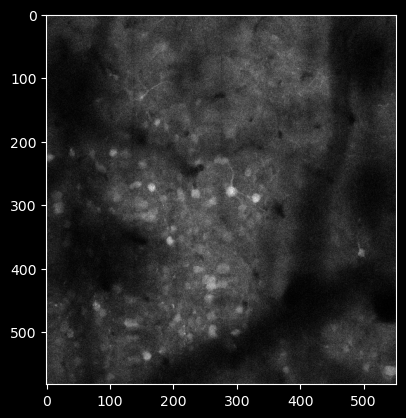

In [27]:
plt.imshow(clear_zeros(scan)[1,...], cmap='gray')
plt.show()

(-0.5, 551.5, 582.5, -0.5)

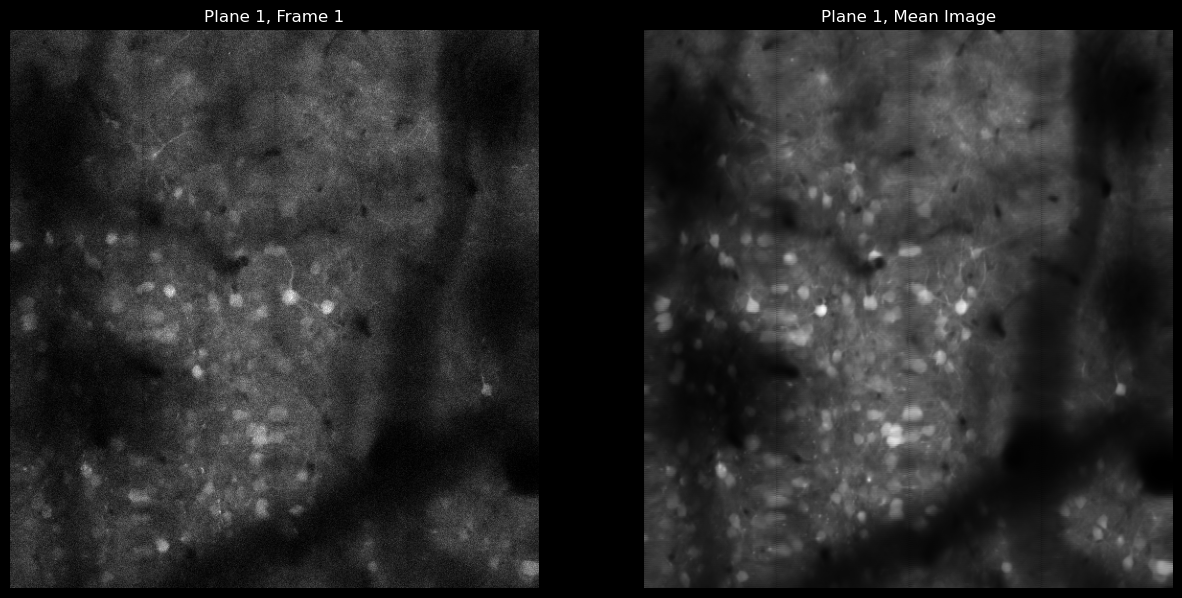

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(clear_zeros(scan)[1,...], cmap='gray')
ax[0].axis('off')
ax[0].set_title('Plane 1, Frame 1')
ax[1].imshow(np.mean(clear_zeros(scan)[1:,...], axis=0), cmap='gray')
ax[1].set_title('Plane 1, Mean Image')
ax[1].axis('off')

In [33]:
df = pd.DataFrame(index=range(0, reader.num_channels), columns=['Channel', 'Mean Time'])

def plot_mean_images(_reader):
    fig, ax = plt.subplots(5, 5, figsize=(15, 15))
    ax = ax.flatten()

    for idx in range(min(25, _reader.num_channels)):
        # extract and plot mean image for each z-plane
        plane = clear_zeros(_reader[2:802, idx, :,:])
        mean_image = np.mean(plane, axis=0)
        ax[idx].imshow(mean_image, cmap='gray')
        ax[idx].axis('off')

    plt.tight_layout()
    plt.show()

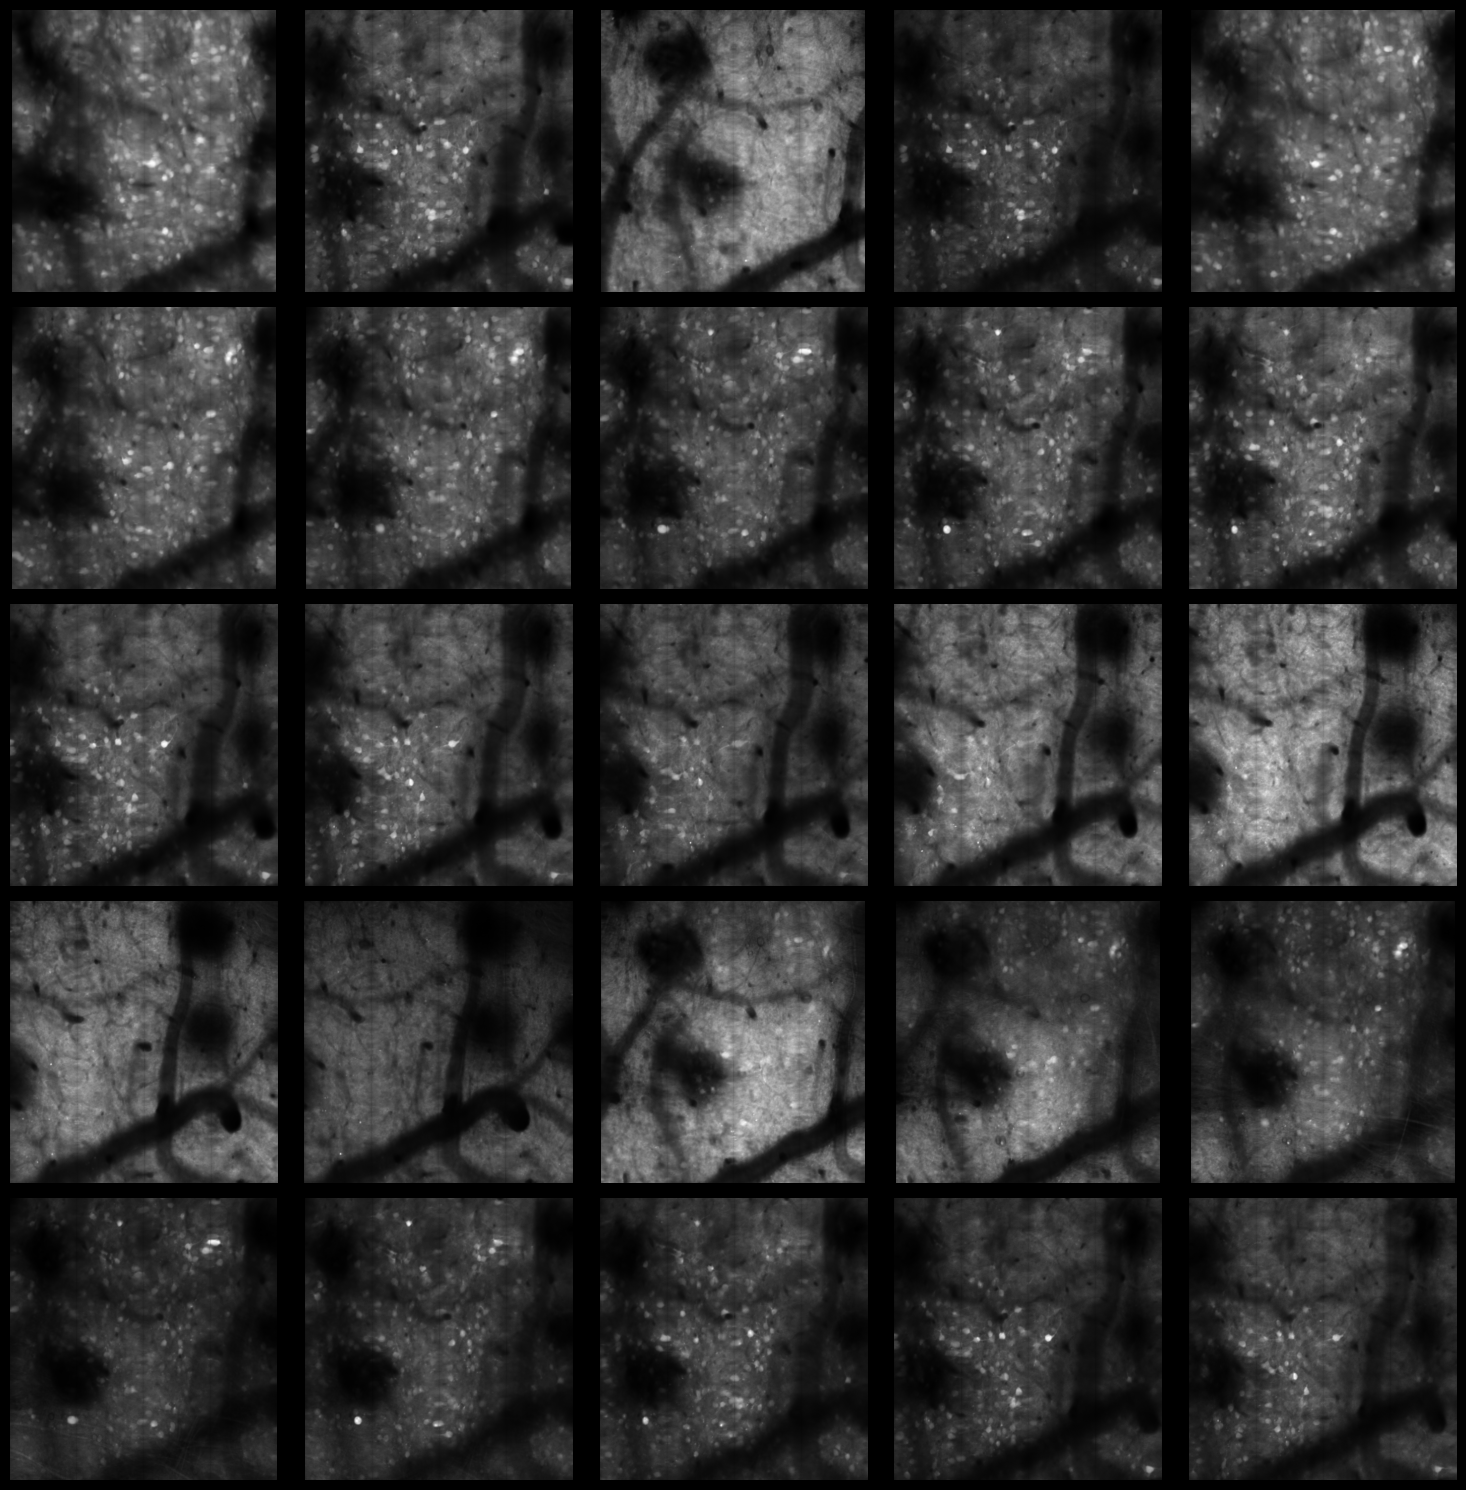

In [34]:
plot_mean_images(reader)

## Save as `.tiff`

In [47]:
sframes = (2, 802)
nframes = sframes[-1] - sframes[0]

savedir = raw_dir / 'final'
savedir.mkdir(exist_ok=True)
for idx, num in enumerate(range(1, reader.num_channels + 1)):
    filename = savedir / f'extracted_plane_{num}.tif'
    if idx in [0, 1]:
        plane = clear_zeros(reader[2:802, idx, :,:])
        tifffile.imwrite(filename, plane, ome=True, bigtiff=True, metadata={'fps': reader.fps, 'photometric': 'minisblack'})

In [48]:
start = time.time()
test_data = tifffile.imread(savedir / 'extracted_plane_1.tif')
print(time.time() - start)

0.14771318435668945


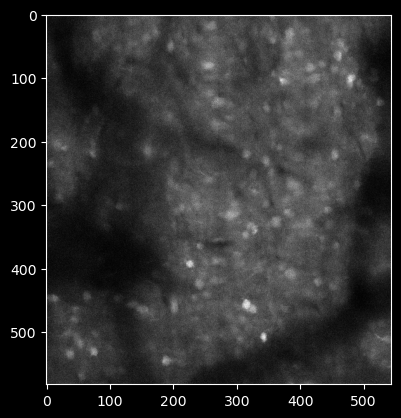

In [50]:
plt.imshow(test_data[0, ...], cmap='gray')
plt.show()